# Crop price recommender system

In [24]:
# IMPORTING FILES
import pandas as pd
import numpy as np
from pathlib import PurePosixPath, PureWindowsPath
from matplotlib import pyplot as plt
import tensorflow as tf

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# IN-HOUSE FUNCTION: RETURN DIRECTORY SPECIFIC TO RUNNING OS
def get_directory(path):
    if os.name == 'posix':
        return str(PurePosixPath(path))
    else:
        return str(PureWindowsPath(path))

In [321]:
# VARIABLES
HARGAPANGAN_LOCATION = get_directory('./dataset/time-series')
TRAIN_SPLIT = 0.8
WINDOW_SIZE = 128
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

# TEST
print(HARGAPANGAN_LOCATION)

dataset\time-series


For the following code block, we are getting all the data from four excel files (trust me, the data is spread horizontally and I don't wanna mess too much)

In [4]:
_APPLE = pd.read_excel(get_directory(HARGAPANGAN_LOCATION + '/Harga Pangan - Compiled.xlsx'), skiprows=1, sheet_name='apel').set_index('Tanggal')
_ORANGE = pd.read_excel(get_directory(HARGAPANGAN_LOCATION + '/Harga Pangan - Compiled.xlsx'), skiprows=1, sheet_name='jeruk').set_index('Tanggal')

In [5]:
# Clean data from strips
_APPLE.loc[:, 'Harga Lokal'] = _APPLE['Harga Lokal'].replace('-', np.NaN)
_APPLE.loc[:, 'Harga Impor'] = _APPLE['Harga Lokal'].replace('-', np.NaN)
_ORANGE.loc[:, 'Harga Lokal'] = _ORANGE['Harga Lokal'].replace('-', np.NaN)
_ORANGE.loc[:, 'Harga Impor'] = _ORANGE['Harga Lokal'].replace('-', np.NaN)

In [6]:
_APPLE

,Harga Impor,Harga Lokal
Tanggal,,
15/12/2017,25000.0,25000.0
18/12/2017,23350.0,23350.0
19/12/2017,24150.0,24150.0
20/12/2017,23850.0,23850.0
21/12/2017,22750.0,22750.0
...,...,...
24/05/2021,28150.0,28150.0
25/05/2021,28150.0,28150.0
26/05/2021,30000.0,30000.0


In [7]:
# Filling up NaN values for Apple
for i in range(len(_APPLE['Harga Lokal'].index)):
    if _APPLE.loc[_APPLE.index[i], 'Harga Lokal'] != _APPLE.loc[_APPLE.index[i], 'Harga Lokal']:   # check for NaN
        _temp = np.array([])
        for j in range(-2, 3):
            if _APPLE.loc[_APPLE.index[i+j], 'Harga Lokal'] == _APPLE.loc[_APPLE.index[i+j], 'Harga Lokal']:
                _temp = np.append(_temp, _APPLE.loc[_APPLE.index[i+j], 'Harga Lokal'])
        _APPLE.loc[_APPLE.index[i], 'Harga Lokal'] = sum(_temp) / len(_temp)

# Filling up NaN values for Orange
for i in range(len(_ORANGE['Harga Lokal'].index)):
    if _ORANGE.loc[_ORANGE.index[i], 'Harga Lokal'] != _ORANGE.loc[_ORANGE.index[i], 'Harga Lokal']:   # check for NaN
        _temp = np.array([])
        for j in range(-2, 3):
            if _ORANGE.loc[_ORANGE.index[i+j], 'Harga Lokal'] == _ORANGE.loc[_ORANGE.index[i+j], 'Harga Lokal']:
                _temp = np.append(_temp, _ORANGE.loc[_ORANGE.index[i+j], 'Harga Lokal'])
        _ORANGE.loc[_ORANGE.index[i], 'Harga Lokal'] = sum(_temp) / len(_temp)

In [8]:
_APPLE.loc['28/05/2021', 'Harga Lokal']

27500.0

In [9]:
len(np.shape(np.array(_APPLE['Harga Lokal'])))

1

In [10]:
_APPLE

,Harga Impor,Harga Lokal
Tanggal,,
15/12/2017,25000.0,25000.0
18/12/2017,23350.0,23350.0
19/12/2017,24150.0,24150.0
20/12/2017,23850.0,23850.0
21/12/2017,22750.0,22750.0
...,...,...
24/05/2021,28150.0,28150.0
25/05/2021,28150.0,28150.0
26/05/2021,30000.0,30000.0


In [11]:
_ORANGE

,Harga Impor,Harga Lokal
Tanggal,,
15/12/2017,10000.0,10000.0
18/12/2017,15000.0,15000.0
19/12/2017,17500.0,17500.0
20/12/2017,20500.0,20500.0
21/12/2017,22250.0,22250.0
...,...,...
24/05/2021,17200.0,17200.0
25/05/2021,16600.0,16600.0
26/05/2021,14500.0,14500.0


In [12]:
_APPLE.index

Index(['15/12/2017', '18/12/2017', '19/12/2017', '20/12/2017', '21/12/2017',
       '22/12/2017', '27/12/2017', '28/12/2017', '29/12/2017', '02/01/2018',
       ...
       '17/05/2021', '18/05/2021', '19/05/2021', '20/05/2021', '21/05/2021',
       '24/05/2021', '25/05/2021', '26/05/2021', '27/05/2021', '28/05/2021'],
      dtype='object', name='Tanggal', length=886)

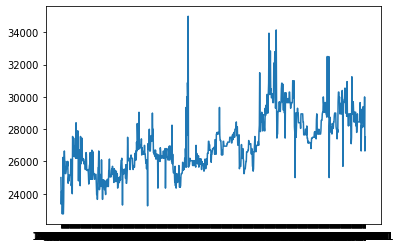

<Figure size 1152x648 with 0 Axes>

In [13]:
# Here is the time series for the average apple price in Indonesia

plt.plot(_APPLE.index, _APPLE['Harga Lokal'])
plt.figure(figsize=(16,9))
plt.show()

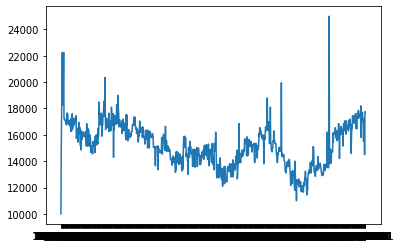

<Figure size 1152x648 with 0 Axes>

In [14]:
# Here is the time series for the average orange price in Indonesia

plt.plot(_ORANGE.index, _ORANGE['Harga Lokal'])
plt.figure(figsize=(16,9))
plt.show()

In [15]:
_APPLE.describe()

,Harga Impor,Harga Lokal
count,880.000000,886.000000
mean,27091.079545,27108.733070
std,1746.941900,1757.344304
min,22750.000000,22750.000000
25%,25850.000000,25850.000000
50%,26800.000000,26800.000000
75%,28200.000000,28250.000000
max,35000.000000,35000.000000


In [16]:
_ORANGE.describe()

,Harga Impor,Harga Lokal
count,880.000000,886.000000
mean,15209.545455,15209.062265
std,1615.887355,1616.234228
min,10000.000000,10000.000000
25%,14000.000000,14000.000000
50%,15150.000000,15150.000000
75%,16362.500000,16387.500000
max,25000.000000,25000.000000


## Data preparation - for machine learning model

In [17]:
# Data normalisation
_APPLE.loc[:, 'Harga Lokal'] = _APPLE['Harga Lokal'] / int(_APPLE['Harga Lokal'].max())
_ORANGE.loc[:, 'Harga Lokal'] = _ORANGE['Harga Lokal'] / int(_ORANGE['Harga Lokal'].max())

In [18]:
# Sanity check
_APPLE

,Harga Impor,Harga Lokal
Tanggal,,
15/12/2017,25000.0,0.714286
18/12/2017,23350.0,0.667143
19/12/2017,24150.0,0.690000
20/12/2017,23850.0,0.681429
21/12/2017,22750.0,0.650000
...,...,...
24/05/2021,28150.0,0.804286
25/05/2021,28150.0,0.804286
26/05/2021,30000.0,0.857143


In [19]:
# Train-test split
_count = len(_APPLE)
_APPLE_LOCAL = _APPLE['Harga Lokal']
_APPLE_TRAIN = np.array(_APPLE_LOCAL[:int(_count*TRAIN_SPLIT)])
_APPLE_TEST = np.array(_APPLE_LOCAL[int(_count*TRAIN_SPLIT):])

In [20]:
_APPLE_TRAIN

array([0.71428571, 0.66714286, 0.69      , 0.68142857, 0.65      ,
       0.67142857, 0.75      , 0.65      , 0.67142857, 0.74285714,
       0.76142857, 0.74285714, 0.74285714, 0.72142857, 0.72142857,
       0.72571429, 0.73428571, 0.73      , 0.74285714, 0.73428571,
       0.74285714, 0.70428571, 0.71285714, 0.71857143, 0.70857143,
       0.71857143, 0.71857143, 0.71857143, 0.71857143, 0.74714286,
       0.7       , 0.70571429, 0.71857143, 0.68571429, 0.78714286,
       0.77428571, 0.75285714, 0.78428571, 0.77      , 0.75142857,
       0.75142857, 0.77      , 0.77      , 0.74857143, 0.81142857,
       0.76571429, 0.76428571, 0.74857143, 0.75714286, 0.79714286,
       0.78142857, 0.70857143, 0.76285714, 0.74714286, 0.76285714,
       0.74285714, 0.7       , 0.78714286, 0.73857143, 0.76571429,
       0.74857143, 0.78428571, 0.75285714, 0.74428571, 0.74714286,
       0.74428571, 0.74714286, 0.73857143, 0.74285714, 0.74      ,
       0.74      , 0.72857143, 0.74571429, 0.75857143, 0.75571

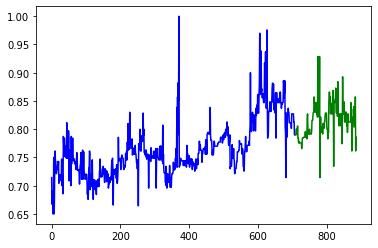

In [21]:
# Visualize the difference between train and test
plt.plot(
    range(int(_count * TRAIN_SPLIT)), _APPLE_TRAIN, 'b',
    range(int(_count * TRAIN_SPLIT), _count), _APPLE_TEST, 'g'
)
plt.show()

In [322]:
# Nyomot dari Mr. Moroney ya yang ini :)
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [323]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

tf.keras.backend.clear_session()
_input = windowed_dataset(_APPLE_TRAIN, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)
_input_val = windowed_dataset(_APPLE_TEST, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

In [25]:
time_series_pred = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = False)),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
])

learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-10 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-10, momentum = 0.9)
time_series_pred.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ['mae', 'acc']
)

history_opt = time_series_pred.fit(
    _input,
    epochs = 250,
    callbacks = [learning_rate_scheduler]
)

 - 1s 55ms/step - loss: 0.3024 - mae: 0.7763 - acc: 0.0000e+00
Epoch 78/250
17/17 [==============================] - 1s 53ms/step - loss: 0.3018 - mae: 0.7754 - acc: 0.0000e+00
Epoch 79/250
17/17 [==============================] - 1s 56ms/step - loss: 0.3009 - mae: 0.7744 - acc: 0.0000e+00
Epoch 80/250
17/17 [==============================] - 1s 59ms/step - loss: 0.2978 - mae: 0.7704 - acc: 0.0000e+00
Epoch 81/250
17/17 [==============================] - 1s 56ms/step - loss: 0.3012 - mae: 0.7746 - acc: 0.0000e+00
Epoch 82/250
17/17 [==============================] - 1s 55ms/step - loss: 0.2989 - mae: 0.7715 - acc: 0.0000e+00
Epoch 83/250
17/17 [==============================] - 1s 55ms/step - loss: 0.2981 - mae: 0.7708 - acc: 0.0000e+00
Epoch 84/250
17/17 [==============================] - 1s 56ms/step - loss: 0.2979 - mae: 0.7704 - acc: 0.0000e+00
Epoch 85/250
17/17 [==============================] - 1s 55ms/step - loss: 0.2981 - mae: 0.7706 - acc: 0.0000e+00
Epoch 86/250
17/17 [=====

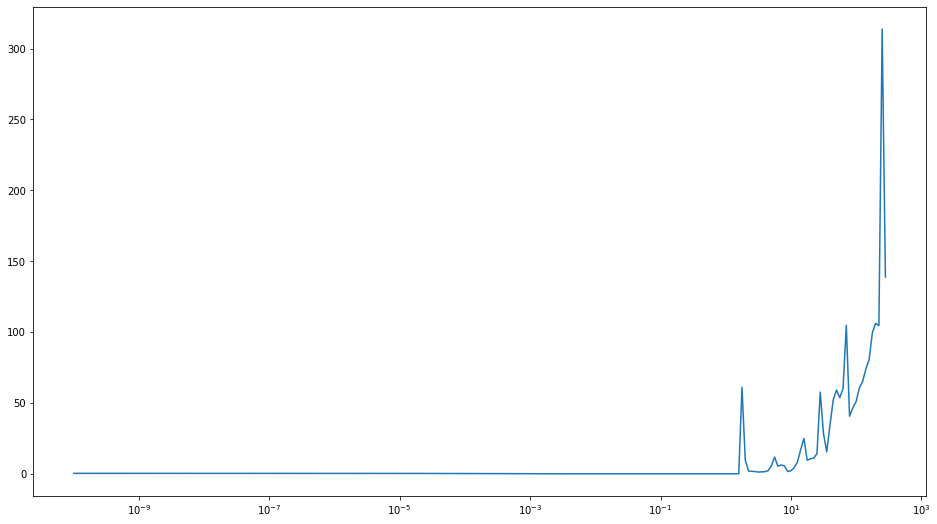

In [26]:
plt.figure(figsize=(16,9))
plt.semilogx(history_opt.history['lr'], history_opt.history['loss'])
plt.show()

Optimizer - second try

In [37]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

tf.keras.backend.clear_session()

time_series_pred = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = False)),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
])

learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-4, momentum = 0.9)
time_series_pred.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ['mae', 'acc']
)

history_opt = time_series_pred.fit(
    _input,
    epochs = 80,
    callbacks = [learning_rate_scheduler]
)

Epoch 1/80
17/17 [==============================] - 8s 57ms/step - loss: 0.2984 - mae: 0.7712 - acc: 0.0000e+00
Epoch 2/80
17/17 [==============================] - 1s 56ms/step - loss: 0.2673 - mae: 0.7294 - acc: 0.0000e+00
Epoch 3/80
17/17 [==============================] - 1s 54ms/step - loss: 0.2245 - mae: 0.6684 - acc: 0.0000e+00
Epoch 4/80
17/17 [==============================] - 1s 55ms/step - loss: 0.1846 - mae: 0.6054 - acc: 0.0000e+00
Epoch 5/80
17/17 [==============================] - 1s 56ms/step - loss: 0.1463 - mae: 0.5388 - acc: 0.0000e+00
Epoch 6/80
17/17 [==============================] - 1s 57ms/step - loss: 0.1161 - mae: 0.4797 - acc: 0.0000e+00
Epoch 7/80
17/17 [==============================] - 1s 54ms/step - loss: 0.0886 - mae: 0.4181 - acc: 0.0000e+00
Epoch 8/80
17/17 [==============================] - 1s 56ms/step - loss: 0.0644 - mae: 0.3560 - acc: 0.0000e+00
Epoch 9/80
17/17 [==============================] - 1s 55ms/step - loss: 0.0443 - mae: 0.2937 - acc: 0.0

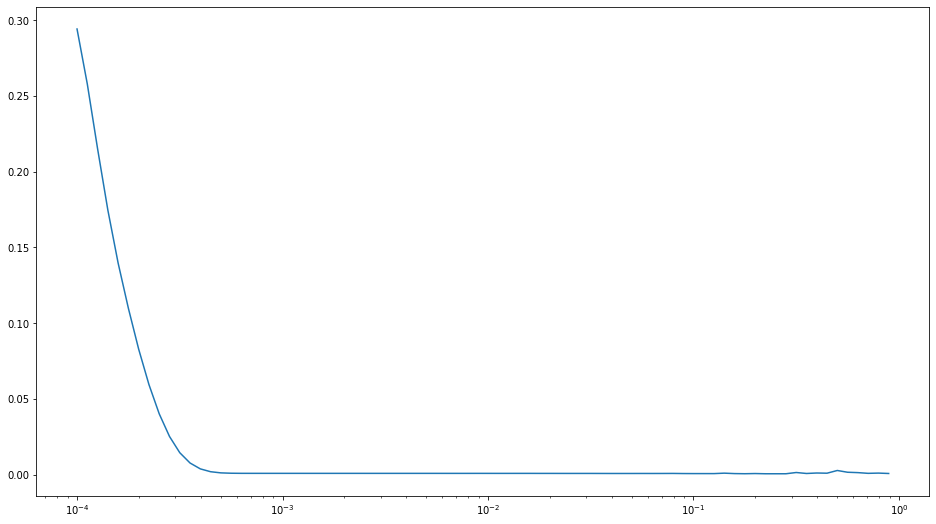

In [38]:
plt.figure(figsize=(16,9))
plt.semilogx(history_opt.history['lr'], history_opt.history['loss'])
plt.show()

Verdict: we get 1e-3 as our learning rate.

In [387]:
# Learning - for real
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

tf.keras.backend.clear_session()

time_series_pred = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    #tf.keras.layers.LSTM(64, return_sequences = True),
    #tf.keras.layers.LSTM(64, return_sequences = False),
    #tf.keras.layers.GRU(64),
    #tf.keras.layers.Dropout(0.5),   # Dropout is attributed to https://arxiv.org/abs/1901.00069
    #tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate = 5e-5, momentum = 0.9)
time_series_pred.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = optimizer,
    #optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5),
    metrics = ['mse']
)

history = time_series_pred.fit(
    _input,
    epochs = 150,
    validation_data = _input_val
)

==================] - 0s 6ms/step - loss: 0.3779 - mse: 0.3779 - val_loss: 0.3820 - val_mse: 0.3820
Epoch 3/150
19/19 [==============================] - 0s 6ms/step - loss: 0.3315 - mse: 0.3315 - val_loss: 0.3370 - val_mse: 0.3370
Epoch 4/150
19/19 [==============================] - 0s 6ms/step - loss: 0.2938 - mse: 0.2938 - val_loss: 0.2973 - val_mse: 0.2973
Epoch 5/150
19/19 [==============================] - 0s 5ms/step - loss: 0.2591 - mse: 0.2591 - val_loss: 0.2625 - val_mse: 0.2625
Epoch 6/150
19/19 [==============================] - 0s 5ms/step - loss: 0.2269 - mse: 0.2269 - val_loss: 0.2317 - val_mse: 0.2317
Epoch 7/150
19/19 [==============================] - 0s 6ms/step - loss: 0.1979 - mse: 0.1979 - val_loss: 0.2049 - val_mse: 0.2049
Epoch 8/150
19/19 [==============================] - 0s 5ms/step - loss: 0.1783 - mse: 0.1783 - val_loss: 0.1813 - val_mse: 0.1813
Epoch 9/150
19/19 [==============================] - 0s 5ms/step - loss: 0.1565 - mse: 0.1565 - val_loss: 0.1604 -

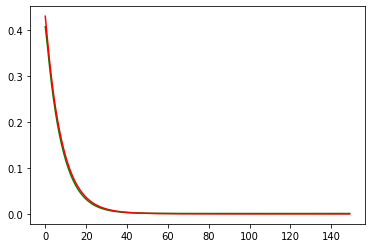

In [388]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], 'g', range(len(history.history['val_loss'])), history.history['val_loss'], 'r')
plt.show()

Predicting 579

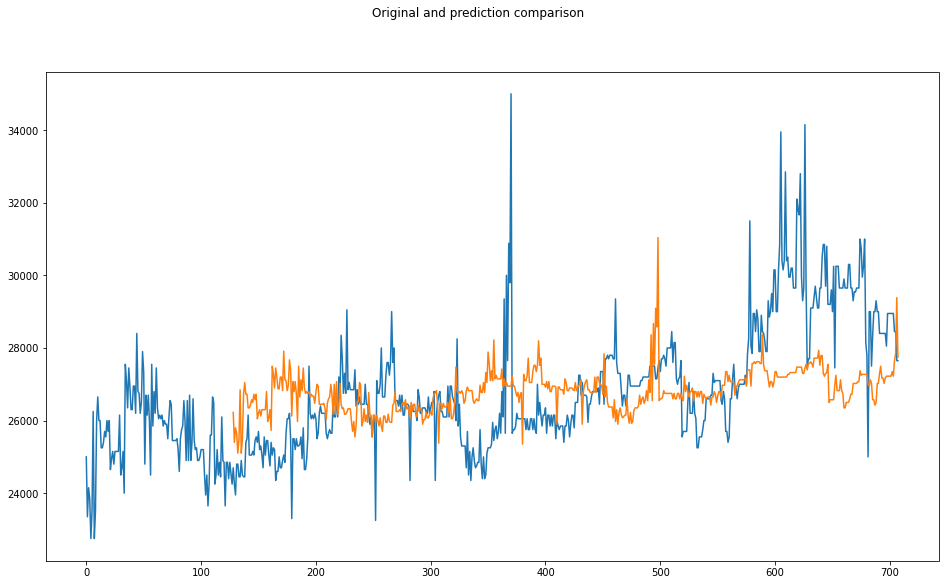

In [389]:
forecast = []
results = []
for i in range(len(_APPLE_TRAIN) - WINDOW_SIZE):
    print('\r'+'Predicting '+str(i), end='')
    forecast.append(time_series_pred.predict(_APPLE_TRAIN[i:i + WINDOW_SIZE][np.newaxis]))

results = np.array(forecast)[:, 0, 0]

fig = plt.figure(figsize=(16,9))
plt.suptitle('Original and prediction comparison')
plt.plot(range(len(_APPLE_TRAIN)), _APPLE_TRAIN * 35000)
plt.plot(range(WINDOW_SIZE, len(results) + WINDOW_SIZE), results * 35000)
plt.show()

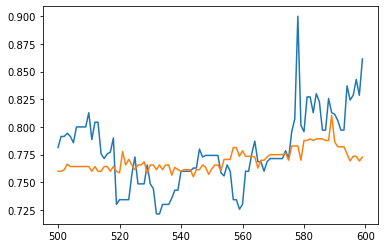

In [390]:
# FOCUS ON SEVERAL SPACE
plt.plot(range(500, 600), _APPLE_LOCAL.values[500:600])
plt.plot(range(500, 600), results[500-WINDOW_SIZE:600-WINDOW_SIZE])

Predicting 49

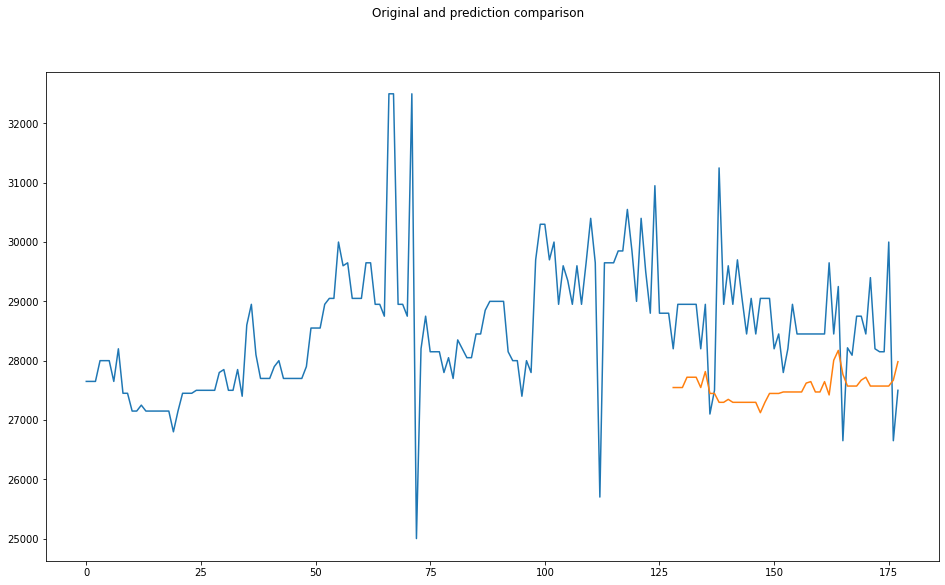

In [391]:
forecast_val = []
results_val = []
for i in range(len(_APPLE_TEST) - WINDOW_SIZE):
    print('\r'+'Predicting '+str(i), end='')
    forecast_val.append(time_series_pred.predict(_APPLE_TEST[i:i + WINDOW_SIZE][np.newaxis]))

results_val = np.array(forecast_val)[:, 0, 0]

fig = plt.figure(figsize=(16,9))
plt.suptitle('Original and prediction comparison')
plt.plot(range(len(_APPLE_TEST)), _APPLE_TEST * 35000)
plt.plot(range(WINDOW_SIZE, len(results_val) + WINDOW_SIZE), results_val * 35000)
plt.show()

In [392]:
# Can it recommend prices for 128 more days? (SPOILER: DOWNSIDE MITIGATED MUCH)
forecast_1y = forecast.copy()
results_1y = results.copy()

for i in range(128):
    print('\r'+'Forecasting '+str(i), end='')
    _temp = time_series_pred.predict(results_1y[
        -1 * WINDOW_SIZE:
        ][np.newaxis])
    results_1y = np.append(results_1y, _temp[0, 0])

#results_1y = results_1y[:, 0, 0]

Forecasting 127

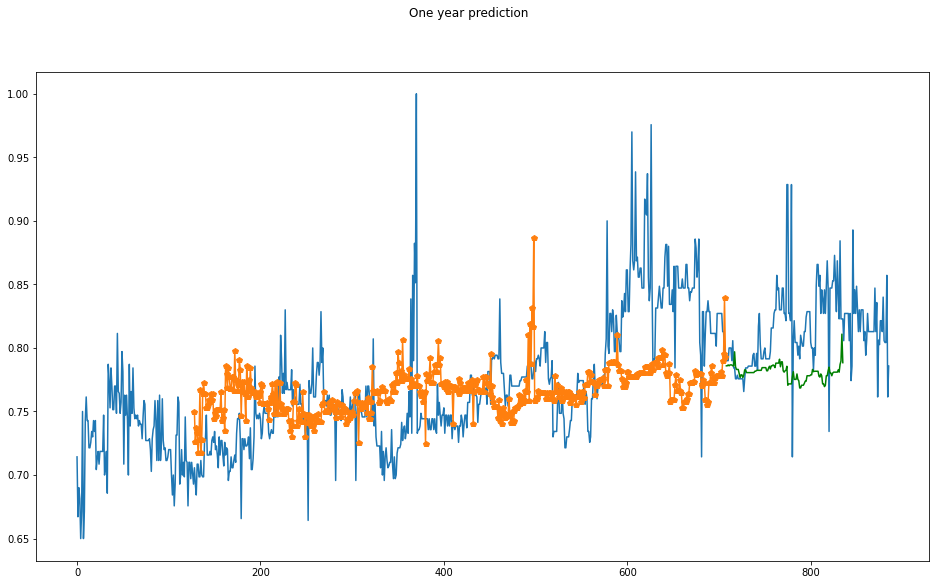

In [393]:
fig = plt.figure(figsize=(16,9))
plt.suptitle('One year prediction')
plt.plot(range(len(_APPLE_LOCAL.values)), _APPLE_LOCAL.values)
plt.plot(range(WINDOW_SIZE, len(_APPLE_TRAIN)), results_1y[:len(_APPLE_TRAIN) - WINDOW_SIZE], 'p-')
plt.plot(range(len(_APPLE_TRAIN), len(_APPLE_TRAIN) + 128), results_1y[-128:], 'g')
plt.show()

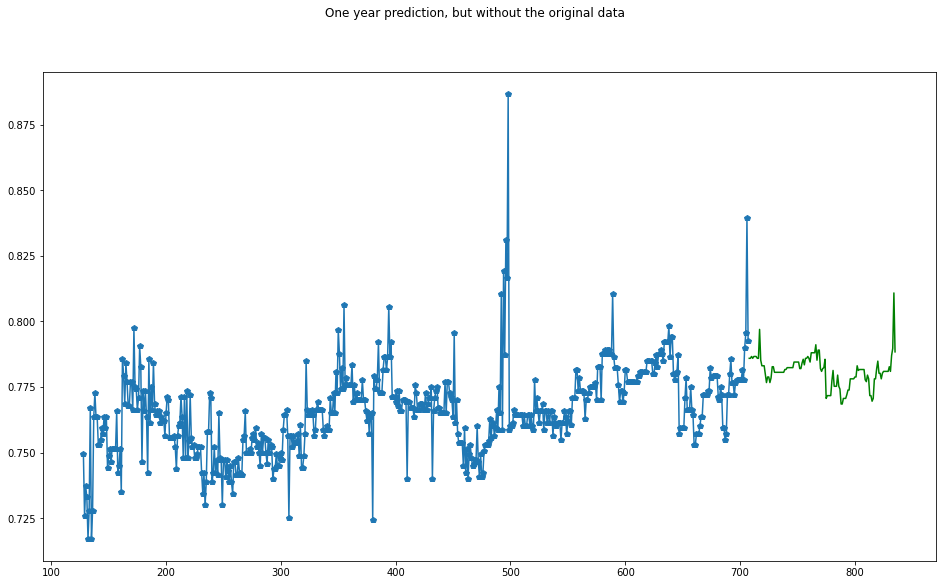

In [394]:
fig = plt.figure(figsize=(16,9))
plt.suptitle('One year prediction, but without the original data')
plt.plot(range(WINDOW_SIZE, len(_APPLE_TRAIN)), results_1y[:len(_APPLE_TRAIN) - WINDOW_SIZE], 'p-')
plt.plot(range(len(_APPLE_TRAIN), len(_APPLE_TRAIN) + 128), results_1y[-128:], 'g')
plt.show()

In [395]:
time_series_pred.save_weights('./weights/forecast-normalised/forecast-normalised')
time_series_pred.save('./model/forecast-normalised')
time_series_pred.save('./model/forecast-normalised.h5')

INFO:tensorflow:Assets written to: ./model/forecast-normalised\assets
